# 橋梁における非定常信号解析のHHT適用可能性

土木研究分野において、多くの調査・実験が行われている。調査・実験で計測される物理量は、気温や風向、風速、構造体の変位、荷重など、多岐にわたる。対象とする現象の周波数特性を知る場合、計測データに対して、スペクトル解析を行うことが多い。スペクトル解析では、Fourier解析が一般的に使用されている。しかしながら、Fourier解析ではデータの定常性・周期性を前提としているため、衝撃的な荷重や地震波形といった非定常性の強いデータを扱う場合、解析結果から周波数特性を正確に理解することは難しい。

非定常性の強いデータの周波数特性を把握する場合、短時間Fourier解析やWavelet解析などの時間-周波数解析が有効となる。しかし、短時間Fourier解析は、信号の解析時間窓幅を選択することが難しい。Wavelet解析は、最適なマザーウェーブレットと呼ばれる基底関数を選択することが難しい。

そこで、基底関数を使用せず、Fourier解析やWavelet解析につきまとう時間−周波数の不確定性原理にとらわれない手法をHuangらは提唱した。Huangらの解析手法は、Hilbert-Huang Transform (HHT)と呼ばれている。HHTは、まずはじめにEmpirical Mode Decomposition(EMD)と呼ばれる手法により固有振動モードに分離した後、Hilbert-Spectrum解析を行い、瞬間周波数を求める。HHTは従来の解析手法よりも高い時間・周波数分解能をもち、多くの分野で有用性が示されている。

橋梁の振動特性を理解し、橋梁モニタリングへ活用するために、橋梁におけるHHT適用可能性を調べてみる

## Hilbert Huang Transform

　Hilbert-Huang Transform(HHT)は、1996年にN.Huangが提案した時間-周波数解析手法である。この手法は振動数の時間変動を特徴付ける為に、瞬間の振動数に着目している。そのため、時間と周波数に関する不確定性関係がある双対変換を基礎とした時間−周波数解析と大きく異なる。  
HHTは、物質損傷検出[]や血圧モニタリング[]、バースト的重力波解析[]に用いられてきた。

### Hilbert Spectral Analysis

　Hilbert Spectral Analysis(HSA)は, ある時系列データとそのHilbert変換から複素信号を定義し, 振幅と位相を一意に分解する。$t$を時間, $h(t)$をある時系列データとして, そのHilbert変換を,
\begin{equation}
v(t) = \frac{1}{\pi}P_{V}\int^{\infty}_{-\infty}\frac{h(\tau)}{t-\tau}d\tau
\end{equation}
 $P_{V}$はCauchyの主値積分。  
 $\mathcal{H}$は, $h(t)$と$1/\pi t$の畳み込み積分
 \begin{equation}
 \mathcal{H}[h(t)] = h(t)*\frac{1}{\pi t}
 \end{equation}
 で表される。 $*$は畳み込み積.  
 Fourier変換の$\mathcal{F}$の畳み込みの定理
 \begin{equation}
 \mathcal{F}[x*y] = \mathcal{F}[x](f)\cdot\mathcal{F}[y](f)
 \end{equation}
 を用いると、
 \begin{equation}
 \mathcal{F}\bigl[\mathcal{H}[h]\bigr](f) = \mathcal{F}[h](f)\cdot\mathcal{F}\left[\frac{1}{\pi t}\right](f)
 \end{equation}
 と表せる。$h(t)$のHilbert変換は, $h(t)$と$1/\pi t$のフーリエ変換積で表せる。
 \begin{equation}
     \mathcal{F}\left[\frac{1}{\pi t}\right](f)
     = \frac{1}{\pi}\int^{\infty}_{-\infty}\frac{\mathrm{e}^{-2\pi i ft}}{t}dt
 \end{equation}
 となる。

### HHTの手順

## 実装

In [1]:
import scipy as scp
import numpy as np
from scipy import signal, interpolate
import pylab
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_max_min_ids(y):## 極大極小抽出関数
    maxId = signal.argrelmax(y)
    minId = signal.argrelmin(y)
    return maxId[0], minId[0]

def get_max_min_spline(y,t,spl=3):## splinefunction
    maxId , minId = get_max_min_ids(y)
    f_max = InterpolatedUnivariateSpline(t[maxId],y[maxId],k=spl)
    f_min = InterpolatedUnivariateSpline(t[minId],y[minId],k=spl)
    return f_max, f_min

def get_protIMF(y,t):##prototype IMF
    U, L = get_max_min_spline(y,t)
    mean = (U(t)+L(t))/2
    protIMF = y - mean
    return protIMF, mean

def stoppage_criterion_zerocross(sig):## zerocross criterion
    con = False
    #print len(sig)
    maxima, minima = get_max_min_ids(sig)
    chk = [i for i in range(len(sig)-1) if (sig[i]>=0 and sig[i+1]<=0) or (sig[i]<=0 and sig[i+1]>=0)]
    #print len(chk)
    #print len(maxima)+len(minima)
    if (np.abs(len(chk)-(len(maxima)+len(minima))) <= 1):
        con = True
    return con

def stoppage_criterion_cauchy(sig,t,thr=1.0e-7):## cauchy criterion
    ##入力した信号の任意の点に対して、極大値をつないだエンベロープと極小値を繋いだエンベロープの平均が0であること。
    ##言い換えると、入力した信号のMaxMinエンベロープの平均が、入力した信号に対して十分小さいこと。
    protIMF, mean= get_protIMF(sig,t)
    cauchy = False
    #print (np.sum(np.abs(mean))/np.sum(np.abs(protIMF)))
    if np.sum(mean**2)/np.sum(sig**2) < thr:
        cauchy = True
    return cauchy

def S_stoppage_criterion(i,S=5):## How many times is zerocross criterion called.
    crite = False
    if i==S:
        crite =True
    return crite

def maxmin_condition(y,thr=5):
    maxID,minID=get_max_min_ids(y)
    if len(maxID) < thr or len(minID) < thr:
        return False
    else: return True

### signal test 

まず、周波数と信号の強度が時間変化する信号を作成し、STFTとWavelet解析をする。
次に、HHTを同信号に適用し、比較検討する。

In [3]:
#make test signal
N = 2000

m_a  = 0.9 #Amplitude modulation
f_a  = 2   #Amplitude modulation

f_c  = 50  #Basic freq

m_fm = 1.0   #Frequency modulation
f_f  = 10.0  #Frequency modulation

amp_noiz = 0.5 #
timerange=1 #time range of sample signal
rand = np.random.RandomState(40)

t = np.linspace(0,timerange,N)
y = (1+m_a*np.sin(2*np.pi*f_a*t))*np.sin(2*np.pi*f_c*t+m_fm*np.sin(2*np.pi*f_f*t))


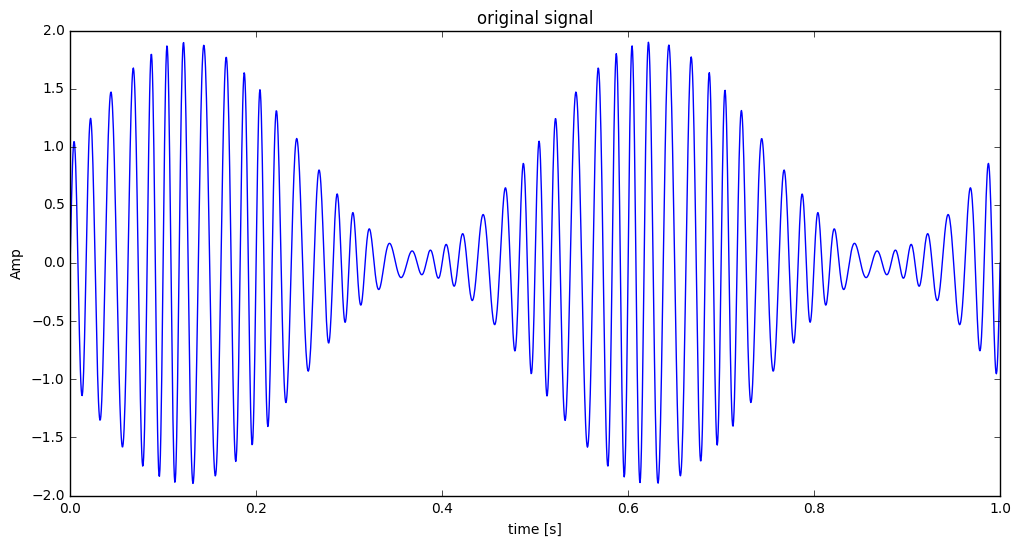

In [4]:
plt.figure(figsize=[12,6])
plt.plot(t,y)
plt.title('original signal')
plt.xlabel('time [s]')
plt.ylabel('Amp')
plt.show()

#### STFT, Wavelet

STFT, Waveletでこの信号を処理する。

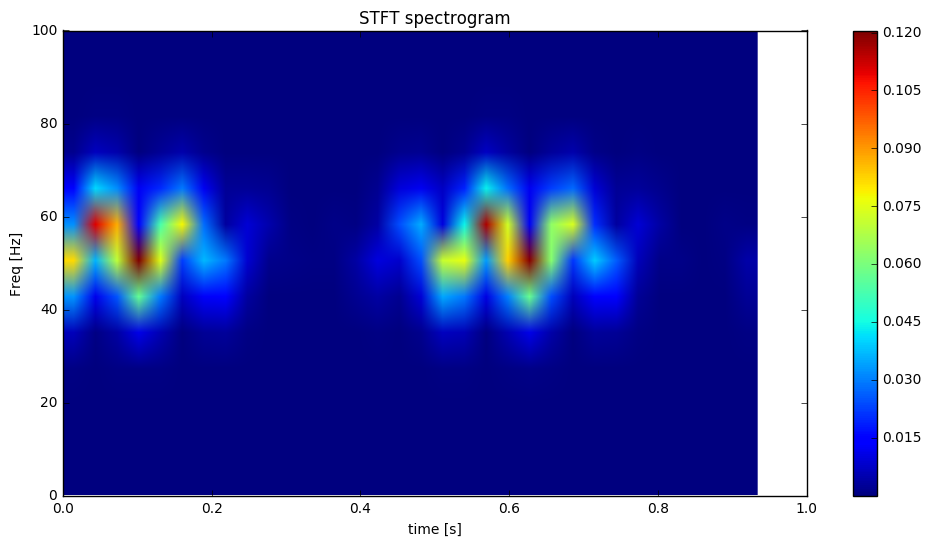

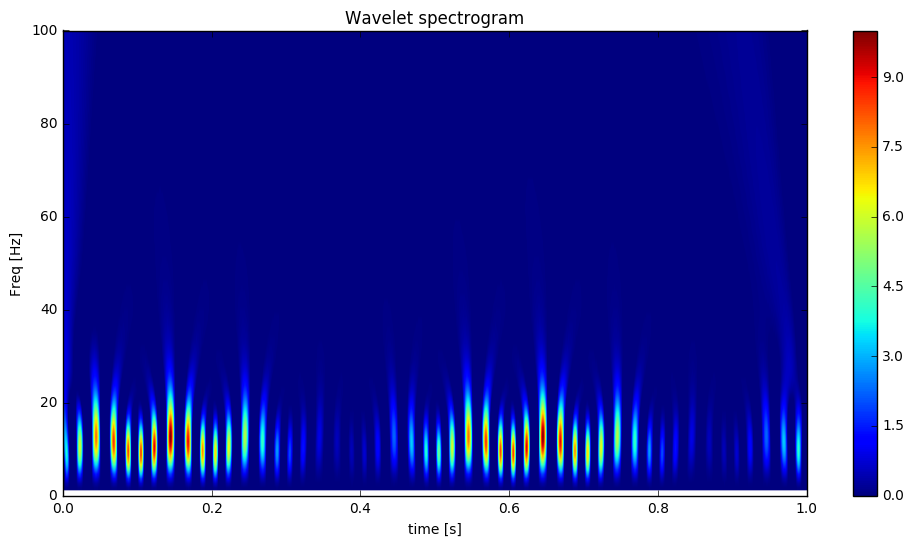

In [95]:
## STFTの結果を示す。
fs = 1./np.abs(t[0]-t[1])
N = 256
hammingwindow = np.hamming(N)

plt.figure(figsize=[12,6])
pxx, freqs, bins, im = pylab.specgram(y ,NFFT = N, Fs = fs, noverlap =200, window = hammingwindow, cmap='jet',scale='linear')

#freq,time,Sxx = signal.spectrogram(y, fs, nperseg=8) #scipy
#plt.pcolormesh(bins,freqs,pxx,cmap='jet')
plt.xlim([0,timerange])
plt.ylim([0,100])
plt.title('STFT spectrogram')
plt.xlabel("time [s]")
plt.ylabel("Freq [Hz]")
plt.colorbar()
plt.show()

#wavelet test
plt.figure(figsize=[12,6])
cwtmatr = signal.cwt(y, signal.ricker, np.arange(1,100))
plt.imshow(cwtmatr, extent=[t.min(), t.max(), 100, 1], cmap='jet', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=0)
plt.ylim([0,100])
plt.title("Wavelet spectrogram")
plt.xlabel("time [s]")
plt.ylabel("Freq [Hz]")
plt.colorbar()
plt.show()



### HHT Algorithm test

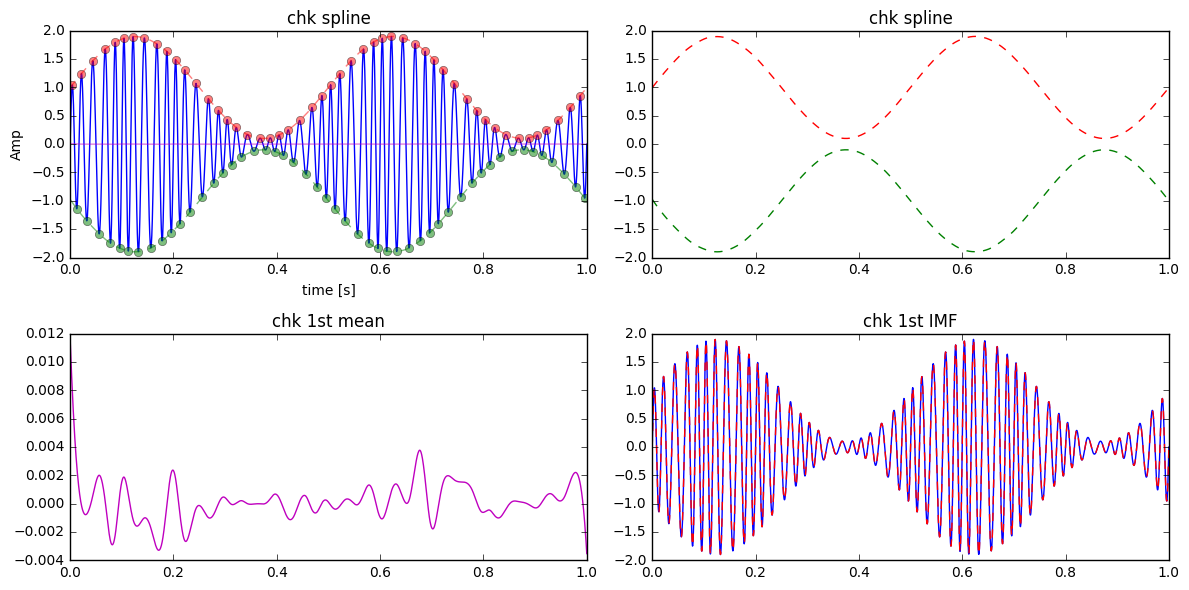

In [10]:
maxId, minId = get_max_min_ids(y) 
f_max, f_min = get_max_min_spline(y,t) 

fig = plt.figure(figsize=[12,6])

ax = fig.add_subplot(221)
ax.set_title('chk spline')
ax.plot(t,y)
ax.plot(t[maxId],y[maxId],'ro',label ='max point',alpha=0.5)
ax.plot(t[minId],y[minId],'go',label ='min point',alpha=0.5)
ax.plot(t,f_max(t),'r--',alpha=0.5)
ax.plot(t,f_min(t),'g--',alpha=0.5)
ax.plot(t,(f_max(t)+f_min(t))/2,'m-',alpha=0.5)
ax.set_xlabel('time [s]')
ax.set_ylabel('Amp')

ax = fig.add_subplot(222)
ax.set_title('chk spline')
ax.plot(t,f_min(t),'g--')
ax.plot(t,f_max(t),'r--')
ax = fig.add_subplot(223)
ax.set_title('chk 1st mean')
ax.plot(t,(f_max(t)+f_min(t))/2,'m-')

ax = fig.add_subplot(224)
ax.set_title('chk 1st IMF')
ax.plot(t,y)
ax.plot(t,y-(f_max(t)+f_min(t))/2,'r--')

fig.tight_layout()
fig.show()

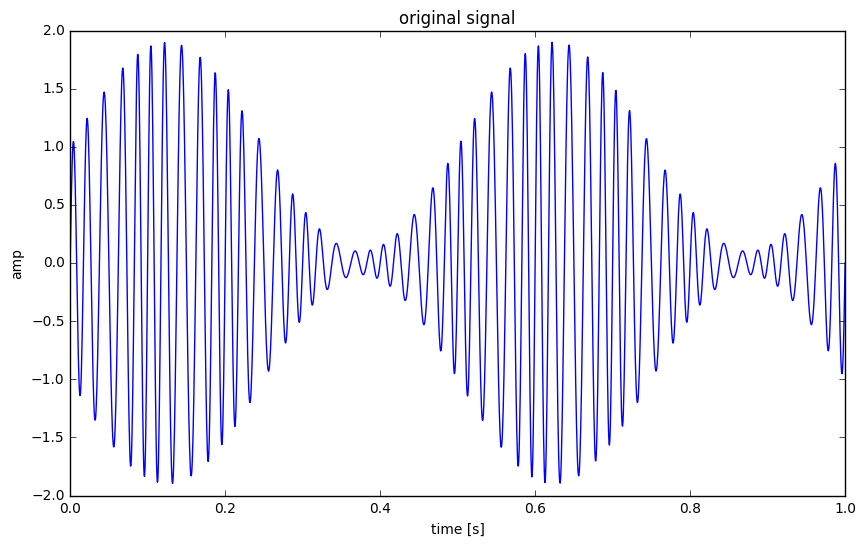

In [11]:
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.set_title('original signal')
ax.set_xlabel('time [s]')
ax.set_ylabel('amp')
ax.plot(t,y)
fig.show()

Algorithmを手書きしてみる。

In [13]:
y_0 = y.copy() ## 生信号yをy0とする。y0を分解していく。
IMFs = [np.zeros(len(y_0))] ##IMF0
##極値が存在するかチェックする
print 'maxmin condition 0:',maxmin_condition(y_0)
temp = y_0.copy()
temp = temp-IMFs[0]
## temp がstoppagecriterionを満たすまで以下の処理を行う。
print 'Caucy0:',stoppage_criterion_cauchy(sig=temp,t=t)
print 'zerocross0:',stoppage_criterion_zerocross(sig=temp)
##両方満たしたのでtempをIMFに加える。
IMFs.append(temp)

maxmin condition 0: True
Caucy0: False
zerocross0: True


IMFsをHSAする。

\begin{equation}
    G(t) = h(t)+iv(t)=a(t)e^{i\theta (t)}
\end{equation}
瞬間振幅(Instantaneous Amplitude: IA)a(t)と瞬間位相$\theta (t)$は、

\begin{eqnarray}
    a(t) &=& \sqrt{h(t)^2+v(t)^2}\\
    \theta (t) &=& arctan\left\{\frac{v(t)}{h(t)}\right\}
\end{eqnarray}
と表される。

In [96]:
len(IMFs)
G = scp.signal.hilbert(IMFs[1])

In [97]:
a = np.abs(G)

In [98]:
Th = np.angle(G)

In [99]:
dt = np.mean(np.gradient(t))

In [100]:
f = np.gradient(Th)/dt/(2*np.pi)

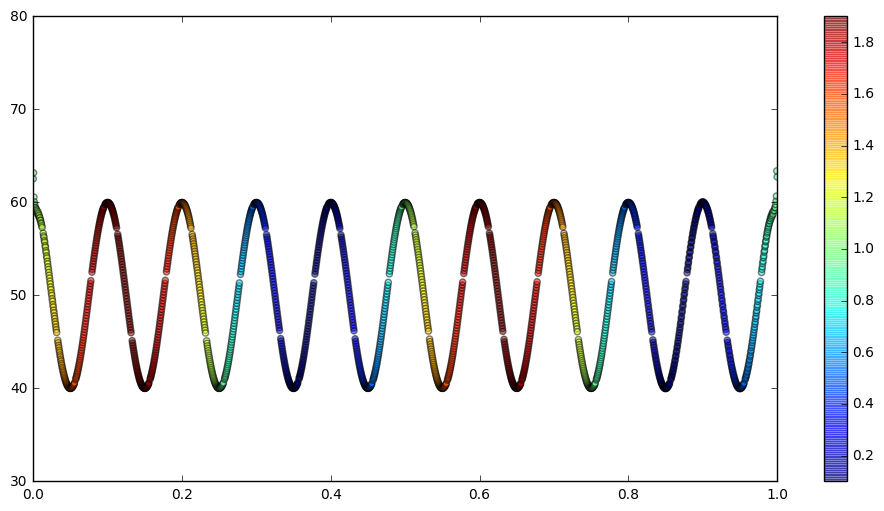

In [101]:
plt.figure(figsize=[12,6])
plt.scatter(t,f,c=a,alpha=0.5,edgecolors=None)
plt.colorbar()
plt.ylim(30,80)
plt.xlim(0,1)
plt.show()

## その他非定常信号解析手法

<img  src='./pic/周波数解析分類.jpeg'/>

### はじめに

　自己回帰モデル( Auto-Regressive: ARモデル ) によるスペクトル推定は、スペクトルが復数のピークを持ち、かつ滑らかなものであると仮定でき、不規則振動の性質が時間的に一定な定常時系列の場合に限られる場合に利用できる有効な方法の１つ。  
　そのため、非定常不規則振動解析には、局在的定常ARモデル( Locally stationary AR: LARモデル )や、時変係数ARモデル( Time Varying Coefficient AR: TVCARモデル )などがある。これらはAR係数が時間変化するモデルであり、係数の時間変化の条件がそれぞれ異なる。  
　TVCARモデルはAR係数の時間変化に滑らかさを導入しているため、滑らかに時間変化するスペクトルが推定できるようになっている。  
　LARモデルでは、定常とみなせる区間を任意に決めていたが、TVCARモデルでは、解析結果を左右させるパラメータを設定する必要がなくなった。しかしながら、TVCARモデルのスペクトルの時間変位の滑らかさは、**スペクトルのパワーを全周波数で積分した値の時間変化が正規分布に従う**という仮定であり、ピーク周波数の時間変化についての滑らかさを意味してはいない。  
　ピーク周波数が時間的に滑らかに変化するモデル( Time Varying Peak frequency of Power spectrum :TVPPモデル)がある。TVCARモデルの場合の間接的な滑らかさの導入に比べて、TVPPモデルはピーク周波数と強度に関するパラメータの時間変化の滑らかさを直接的に定義する。

### ARモデル

#### ARモデルとスペクトル

不規則振動に対するスペクトル解析に於いて、なめらかなスペクトルが推定できる。ARモデルは、

\begin{equation}
y_t = \sum\limits_{k=1}a_{k}y_{t-k}+\varepsilon_t \,\,\,\,\,\,\,\, \varepsilon_t \sim N(0,\sigma^2)
\end{equation}

で表される。  
ARモデルによる、幾つかのピークを持つなめらかなスペクトルは、

\begin{equation}
p(\omega) = \frac{\sigma^2}{\left|1-\sum\limits_{k=1}a_{k}e^{-ik\omega}\right|^2} \label{eq:power_spe_ar_model}
\end{equation}

と表される。解析対象が($\ref{eq:power_spe_ar_model}$)式のように仮定できる場合、ARモデルによる解析は有効。  
　ARモデルの適用は、不規則振動の性質が時間的に一定な、(時系列で)定常系のときに限られる。解析対象の振動特性が時間変化する非定常スペクトルの場合には、単純にARモデルを適用してはいけない。  

### 非定常ARモデル

時変係数ARモデルは、AR係数が時間的に変化するモデル。この非定常ARモデルは、

\begin{equation}
y_t = \sum\limits_{k=1}a_{k}(t)y_{t-k}+\varepsilon_t
\end{equation}

$\varepsilon_t$は、正規分布$N(0,\sigma^2)$に互いに独立に従う。  
非定常ARモデルによる、ある時刻$t$ におけるスペクトルは、

\begin{equation}
p(\omega,t) = \frac{\sigma^2}{\left|1-\sum\limits_{k=1}a_{k}(t)e^{-ik\omega}\right|^2}\label{eq:power_spe_tar_model}
\end{equation}

と表される。  
　得られたデータから、$\sigma^2$と各時刻におけるAR係数$\{a_k(t)|k=1,2,...,n\}$が推定できれば、スペクトルも推定できる。  
　AR係数が各時刻ごとにあるため、パラメータ数はデータ数より多くなることがほとんどであると予想される。有用な推定を行うためには、パラメータ間に制約を設定し、実質的なパラメータの次元を減らすことが必要不可欠。

### 時間的に連続なAR係数を仮定した非定常ARモデル